## Sentiment Analysis for Whispr

1. import data from google sheets
2. clean dataset and create synthetic variables
3. summarize dataset: how many records per category, reviews over time
4. evaluate sentiment of review, give confidence interval
5. calculate summary insights: average sentiment / subjectivity per item, reviews per item
6. compare against manual evaluation
7. export data to google sheets

In [113]:
#operational packages
import pandas as pd
import numpy as np
import string

#packages for google sheets
import gspread
import pygsheets
from oauth2client.service_account import ServiceAccountCredentials

#plotting
from matplotlib import pyplot as plt
import seaborn as sns

#natural language processing
from textblob import TextBlob
import nltk
from nltk import pos_tag_sents, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords, words

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#plot formatting
%matplotlib inline
sns.set_style('darkgrid')
pd.options.display.max_rows = 100

### 1a. Import data from GS using GSpread
- connect to google sheets API
- create spreadsheet and worksheet objects, explore GSpread library
- create dataframe of reviews

In [23]:
#1 define the scope of your access tokens
scope = ['https://www.googleapis.com/auth/drive','https://spreadsheets.google.com/feeds']

#2 after getting oauth2 credentials in a json, obtain an access token from google authorization server
#by creating serviceaccountcredentials and indicating scope, which controls resources / operations that an
#access token permits
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret2.json', scope)

#3 log into the google API using oauth2 credentials
#returns gspread.Client instance
c = gspread.authorize(creds)

spreadsheet = c.open('UK Sentiment')
worksheet = spreadsheet.worksheet('WHotel_Sentiment')
records = worksheet.get_all_records()
df = pd.DataFrame(records)
df = df[['Contents','Sentiment','Topic','Location','Comment']]

### 1b. Import data from GS using pygsheets

In [24]:
#authorization in one step - read client_secret
gc = pygsheets.authorize(service_file='client_secret.json')
spreadsheet2 = gc.open('UK Sentiment')

#clean up workbook 
for item in spreadsheet2.worksheets():
    title = item.title
    if item.title not in ['UK_Reviews','WHotel_Sentiment','WHOTELS_analyzed']:
        worksheet2 = spreadsheet2.worksheet_by_title(str(item.title))
        spreadsheet2.del_worksheet(worksheet2)
        print('{} sheet deleted'.format(item.title))
        
worksheet2 = spreadsheet2.worksheet_by_title('WHotel_Sentiment')
records2 = worksheet2.get_all_records()
df2 = pd.DataFrame(records2)
df2 = df2[['Contents','Sentiment','Topic','Location','Comment']]

#get data for kind bars
kindbar = spreadsheet.worksheet('UK_Reviews')
kindrecords = kindbar.get_all_records()
kind_df = pd.DataFrame(kindrecords)
kind_df = kind_df[['review_rating','Review','review_headline','Product (Taste/Experience)']]

kind_df.head()

,review_rating,Review,review_headline,Product (Taste/Experience)
0,5.0 out of 5 stars,"I really like these bars, and so do the other ...",A very tasty and well-balanced treat,1
1,5.0 out of 5 stars,I purchased these because I’m on the 16:8 IF d...,Great size snack for those of us wanting a hea...,1
2,5.0 out of 5 stars,These are great bars. I find when I'm training...,Price varies a lot !!!,1
3,5.0 out of 5 stars,Not a protein bar but a very health-designed s...,Possibly the best tasting healthiest snack bar...,1
4,5.0 out of 5 stars,So good and actually quite low in sugar all co...,Definitely a bar to try and enjoy,1


### 2. Simple sentiment analysis

In [25]:
#baseline sentiment analysis - use textblob polarity, compare accuracy
df['Sentiment_Category'] = df['Sentiment'].map({1: 'Positive',2:'Neutral',3:'Negative'})

def pos_neg(polarity):
    if polarity >= 0.1:
        return 'Positive'
    if polarity >= 0 and polarity < 0.1:
        return 'Neutral'
    else:
        return 'Negative'

df['Polarity'] = [TextBlob(x).polarity for x in df['Contents']]
df['Subjectivity'] = [TextBlob(x).subjectivity for x in df['Contents']]
df['Textblob_Score'] = df['Polarity'].apply(pos_neg)

df.groupby(['Sentiment_Category','Textblob_Score'])['Polarity'].agg({'mean':np.mean, 'count':len})

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  app.launch_new_instance()


mean  count
Sentiment_Category Textblob_Score                 
Negative           Negative       -0.229419   11.0
                   Neutral         0.003046   72.0
                   Positive        0.379133   55.0
Neutral            Neutral         0.028125    1.0
Positive           Negative       -0.400000    1.0
                   Neutral         0.001145   14.0
                   Positive        0.425419   20.0

### 3. KNN Sentiment Analysis
- data cleaning: remove hashtags and extra whitepsaces
- lemmatize contents
- count word frequencies of lemmatized words
- calculate polarity and choose positive / negative words

In [242]:
#function to convert penn POS tags to wordnet
lemmatizer = WordNetLemmatizer()
def nltk2wn(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None        

#function to lemmatize sentence with appropriate pos
def lemmatize_sent(sentence):
    nltk_tagged = pos_tag([x.lower() for x in nltk.word_tokenize(sentence)])
    converted_tags = [(x[0], nltk2wn(x[1])) for x in nltk_tagged]
    lemmatized_sent = []
    for x in converted_tags:
        if x[1] is None:
            lemmatized_sent.append(x[0])
        else:
            lemmatized_sent.append(lemmatizer.lemmatize(x[0], pos = x[1]))                     
    #final_sentence = ' '.join(lemmatized_sent)
    return lemmatized_sent 

def is_useful(word):
    mystop = stopwords.words('english')
    punctuation = string.punctuation
    englishwords = [x.lower() for x in words.words()]   
    if word not in mystop and word not in punctuation and word in englishwords:
        return True
    else:
        return False

#function to find most popular positive and negative words
def count_words(df, lemmatized_col):
    #create three checks: stopwords, punctuation, english

    allwords = df[lemmatized_col].tolist()
    unnested = [word for sublist in allwords for word in sublist]
    #uniquewords = list(set(test))
    
    #lemmatize words in comments
    #allwords = TextBlob(str(df[lemmatized_col].values.tolist())).tokenize()
    #create list of lemmatized words
    finalwords = [word for word in unnested if is_useful(word)]

    #for lemmatized words, create counts and polarity scores
    counts = {x: finalwords.count(x) for x in finalwords}
    word_df = pd.DataFrame(counts.items(), columns = ['word','count']).sort_values('count', ascending = False)
    word_df['polarity'] = word_df['word'].apply(lambda x: TextBlob(x).polarity)
    positives = word_df[word_df['polarity'] > 0].sort_values(['count','polarity'], ascending = False)
    negatives = word_df[word_df['polarity'] < 0].sort_values(['count','polarity'], ascending = False)

    toptenpos = positives.nlargest(10, columns = 'count').reset_index(drop=True)
    toptenneg = negatives.nlargest(10, columns = 'count').reset_index(drop=True)
    return toptenpos, toptenneg

#function to create dummies for pos and neg words
def pos_dummies(df, review_col, pos_words, neg_words):
    for word in pos_words.values:
        newcol = f'pos_{word[0]}'
        df[newcol] = [1 if word[0] in x else 0 for x in df[review_col]]
    for word in neg_words.values:
        newcol = 'neg_{}'.format(word[0])
        df[newcol] = [1 if word[0] in x else 0 for x in df[review_col]]
    df['pos_total'] = df[[column for column in df.columns if column[0:3] == 'pos']].sum(axis=1)
    df['neg_total'] = df[[column for column in df.columns if column[0:3] == 'neg']].sum(axis=1)
    return df

In [238]:
#lemmatize and tokenize kind bars
kind_df['Lemmatized'] = kind_df['Review'].apply(lemmatize_sent)
kind_pos, kind_neg = count_words(kind_df, 'Lemmatized')

#lemmatize and tokenize whotels
df['Lemmatized'] = df['Contents'].apply(lemmatize_sent)
whotels_pos, whotels_neg = count_words(df, 'Lemmatized')

#get dummies
dummy_kind = pos_dummies(kind_df, 'Lemmatized', kind_pos, kind_neg)

In [160]:
dummy_kind['rating'] = [int(x[0]) for x in dummy_kind['review_rating']]
dummy_kind.rename(columns = {'Product (Taste/Experience)': 'Product'}, inplace = True)
kind_df.dropna(inplace = True)

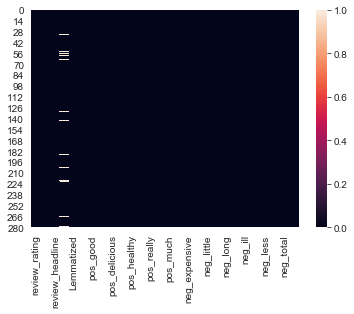

In [104]:
sns.heatmap(dummy_kind.isna())

In [105]:
dummy_kind.groupby(['rating','Product'])[['review_rating']].count()

review_rating
rating Product               
1      1.0                  2
       3.0                  9
2      3.0                  2
3      1.0                  2
       2.0                  5
       3.0                  2
4      1.0                 10
       2.0                  5
       3.0                  3
5      1.0                215
       2.0                 11
       3.0                  1

In [106]:
#graph total positive against rating
dummy_kind.groupby(['pos_total','rating'])[['rating']].count()

rating
pos_total rating        
0         1            5
          3            2
          4            6
          5           60
1         1            6
          2            1
          3            4
          4           13
          5          103
2         1            2
          2            1
          3            2
          4            1
          5           60
3         5           13
4         5            4
6         3            1

([<matplotlib.axis.YTick at 0x1a2c55c590>,
 <a list of 5 Text yticklabel objects>)

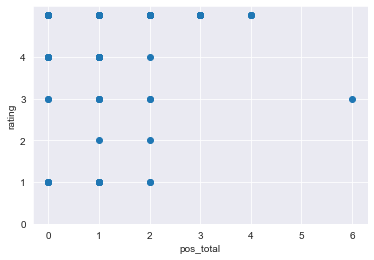

In [107]:
plt.figure()
plt.scatter(dummy_kind['pos_total'],dummy_kind['rating'])
plt.xlabel('pos_total')
plt.ylabel('rating')
plt.yticks(np.arange(0, 5))

In [184]:
columns_to_keep = [column for column in dummy_kind.columns if column[0:3] in ['pos', 'neg', 'rating'] and column != 'neg_dark']
X = kind_df[columns_to_keep]
y = kind_df['Product']

X_train, X_test, y_train, y_test = train_test_split(X, y)
print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_train,  y_train)

#test scores for various train test splits
#test scores for different values of k
#test scores for different weights


X train shape: (200, 21)
X test shape: (67, 21)
y train shape: (200,)
y test shape: (67,)


In [235]:
train_splits = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55]
k_neighbors = range(1,11)
weights = ['uniform','distance']

#def optimize_model()
scores = []
for split in train_splits:
    for neighbor in k_neighbors:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = split)
        knn = KNeighborsClassifier(n_neighbors = neighbor)
        knn.fit(X_train, y_train)
        score = knn.score(X_train, y_train)
        scores.append((neighbor, split, score))
        print('Score for train split of {} with {} neighbors is {}'.format(split, neighbor, score))

score_output = pd.DataFrame(scores, columns = ['n','split','score'])

Score for train split of 0.9 with 1 neighbors is 0.7625
Score for train split of 0.9 with 2 neighbors is 0.8583333333333333
Score for train split of 0.9 with 3 neighbors is 0.8583333333333333
Score for train split of 0.9 with 4 neighbors is 0.8708333333333333
Score for train split of 0.9 with 5 neighbors is 0.8583333333333333
Score for train split of 0.9 with 6 neighbors is 0.85
Score for train split of 0.9 with 7 neighbors is 0.8541666666666666
Score for train split of 0.9 with 8 neighbors is 0.875
Score for train split of 0.9 with 9 neighbors is 0.8625
Score for train split of 0.9 with 10 neighbors is 0.8625
Score for train split of 0.85 with 1 neighbors is 0.7831858407079646
Score for train split of 0.85 with 2 neighbors is 0.8672566371681416
Score for train split of 0.85 with 3 neighbors is 0.8672566371681416
Score for train split of 0.85 with 4 neighbors is 0.8495575221238938
Score for train split of 0.85 with 5 neighbors is 0.8584070796460177
Score for train split of 0.85 with 6 

Text(0, 0.5, 'score')

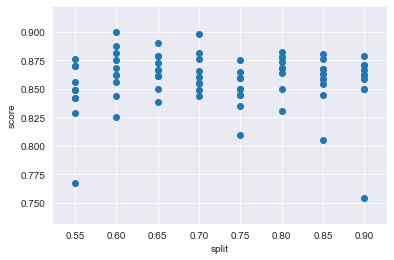

In [213]:
plt.scatter(score_output['split'], score_output['score'])
plt.xlabel('split')
plt.ylabel('score')

Text(0, 0.5, 'score')

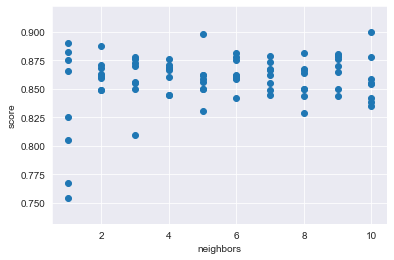

In [215]:
plt.scatter(score_output['n'], score_output['score'])
plt.xlabel('neighbors')
plt.ylabel('score')

In [227]:
[(x, y, z) for (x, y, z) in scores if z == 0.9]

[(10, 0.6, 0.9)]

In [231]:
knn.predict(X_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])